In [11]:
# ==========================================
# 1. IMPORT LIBRARY & SETUP
# ==========================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

# Setup Path
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Cek folder
if not os.path.exists(train_dir):
    print("❌ ERROR: Folder 'train' tidak ditemukan!")
else:
    print("✅ Folder dataset ditemukan.")

✅ Folder dataset ditemukan.


In [12]:
# ==========================================
# 2. DATA GENERATOR DENGAN SPLIT OTOMATIS
# ==========================================
# KUNCI PERBAIKAN: Kita ambil 20% data training untuk validasi agar grafik stabil

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,      # Rotasi jangan terlalu ekstrim
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2    # <--- INI PENTING: Split 20% untuk validasi
)

print("\n--- Menyiapkan Data ---")
# Generator Data Training (80%)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',      # Ambil bagian training
    shuffle=True
)

# Generator Data Validasi (20% dari folder train)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',    # Ambil bagian validasi
    shuffle=False
)


--- Menyiapkan Data ---
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [13]:
# ==========================================
# 3. MENANGANI DATA IMBALANCE (CLASS WEIGHTS)
# ==========================================
# Ini agar model tidak bias ke kelas yang jumlahnya banyak (Pneumonia)

# Mengambil label kelas dari generator
train_labels = train_generator.classes
class_indices = train_generator.class_indices

# Hitung bobot penyeimbang
class_weights_val = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_val))

print(f"\nLabel Mapping: {class_indices}")
print(f"Class Weights (Penyeimbang): {class_weights}")
# Normal biasanya bobotnya lebih besar karena datanya lebih sedikit


Label Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Class Weights (Penyeimbang): {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [14]:
# ==========================================
# 4. ARSITEKTUR MODEL (LEBIH ROBUST)
# ==========================================
model = Sequential([
    # Conv Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Conv Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Conv Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Conv Block 4 - Disederhanakan sedikit agar tidak terlalu berat
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    
    # Dense Layer dengan L2 Regularization (Anti-Overfitting Extra)
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5), # Matikan 50% neuron saat training
    
    # Output Layer
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001), # Speed belajar pelan tapi teliti
              metrics=['accuracy'])

c:\Users\raang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# ==========================================
# 5. CALLBACKS
# ==========================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,             # Tunggu 7 epoch kalau tidak ada perbaikan
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # Kurangi LR setengahnya jika stuck
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [17]:
# ==========================================
# 6. EKSEKUSI TRAINING (REVISI)
# ==========================================
print("\n--- Memulai Training Ulang ---")

# Keras versi baru cukup pintar untuk tahu kapan data habis
# jadi kita hapus 'steps_per_epoch' dan 'validation_steps'

history = model.fit(
    train_generator,
    epochs=20, 
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
    # Parameter steps_per_epoch & validation_steps DIHAPUS saja
)


--- Memulai Training Ulang ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 598ms/step - accuracy: 0.9082 - loss: 1.1015 - val_accuracy: 0.8111 - val_loss: 1.2590 - learning_rate: 5.0000e-05
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 586ms/step - accuracy: 0.9176 - loss: 1.0636 - val_accuracy: 0.9319 - val_loss: 1.0084 - learning_rate: 5.0000e-05
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 590ms/step - accuracy: 0.9185 - loss: 1.0417 - val_accuracy: 0.9386 - val_loss: 1.0183 - learning_rate: 5.0000e-05
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 595ms/step - accuracy: 0.9152 - loss: 1.0326 - val_accuracy: 0.9569 - val_loss: 0.9514 - learning_rate: 5.0000e-05
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 589ms/step - accuracy: 0.9327 - loss: 0.9928 - val_accuracy: 0.9530 - val_loss: 0.9456 - learning_rate: 5.0000e-05
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 587ms/step - accuracy: 0.9255 - loss: 0.9855 - val_accuracy: 0.9664 - val_loss: 0.8997 - learning_rate: 5.0000e-05
Epoch 7/20
131

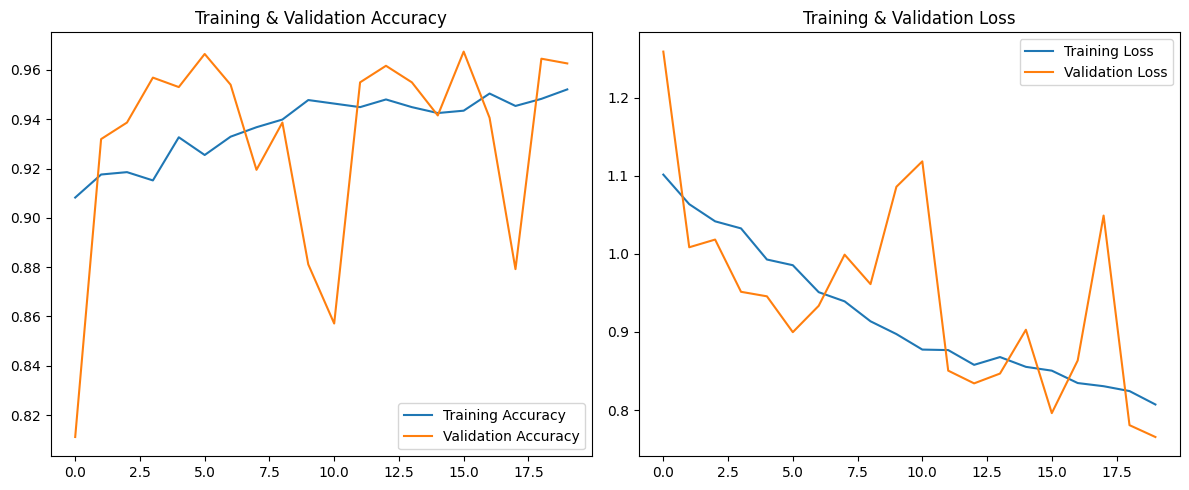


✅ Model tersimpan sebagai 'model_pneumonia_final.h5'


In [18]:
# ==========================================
# 7. EVALUASI HASIL & PLOT
# ==========================================
# Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Simpan Model
model.save('model_pneumonia_final.h5')
print("\n✅ Model tersimpan sebagai 'model_pneumonia_final.h5'")

Menampilkan Sampel Data (Atas: Normal, Bawah: Pneumonia):


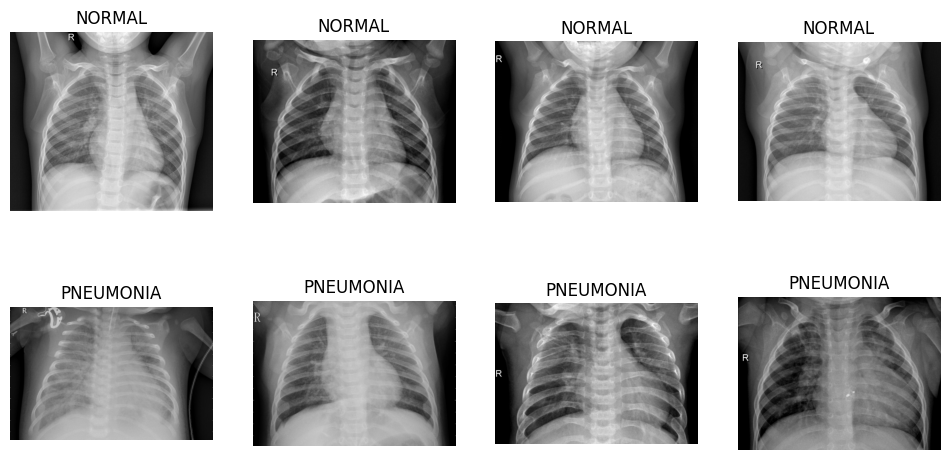

In [20]:
# ==========================================
# VISUALISASI DATA SAMPEL
# ==========================================
import matplotlib.image as mpimg

# Mengatur tampilan gambar (2 baris, 4 kolom)
rows = 2
cols = 4
fig = plt.gcf()
fig.set_size_inches(12, 6)

# Ambil direktori gambar Normal dan Pneumonia
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Ambil nama file gambar (4 teratas)
normal_names = os.listdir(normal_dir)[:4]
pneumonia_names = os.listdir(pneumonia_dir)[:4]

# Gabungkan path gambar
img_paths = [os.path.join(normal_dir, fname) for fname in normal_names] + \
            [os.path.join(pneumonia_dir, fname) for fname in pneumonia_names]

# Loop untuk menampilkan gambar
print("Menampilkan Sampel Data (Atas: Normal, Bawah: Pneumonia):")
for i, img_path in enumerate(img_paths):
    sp = plt.subplot(rows, cols, i + 1)
    sp.axis('Off') # Hilangkan sumbu x/y
    
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    
    if i < 4:
        plt.title("NORMAL")
    else:
        plt.title("PNEUMONIA")

plt.show()

Found 624 images belonging to 2 classes.

Melakukan Prediksi pada Data Test...
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step


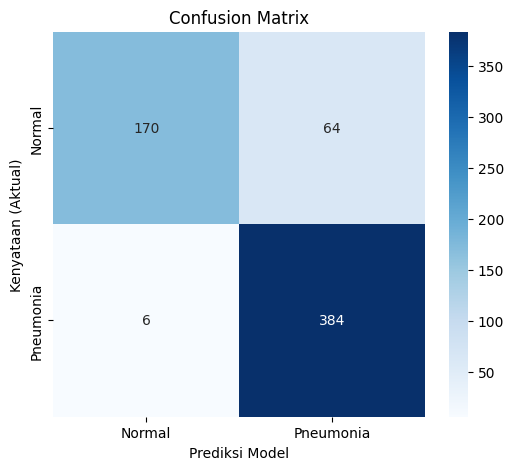


LAPORAN KLASIFIKASI (METRIK EVALUASI)
              precision    recall  f1-score   support

      Normal       0.97      0.73      0.83       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



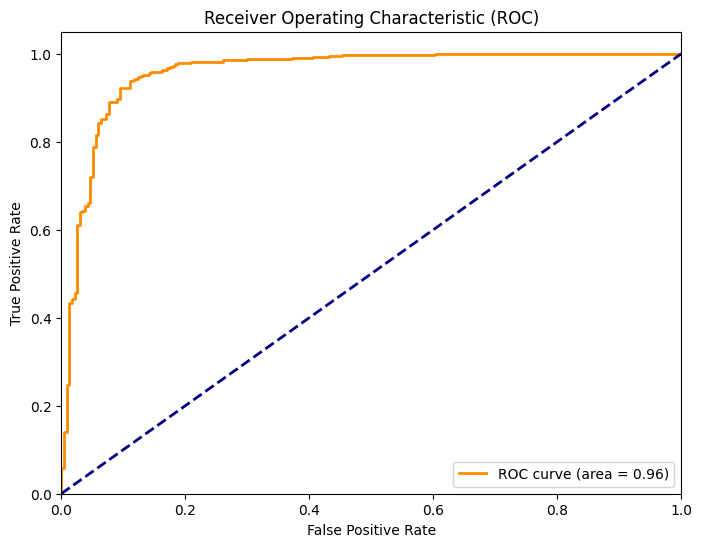

Nilai AUC Score: 0.9585


In [21]:
# ==========================================
# EVALUASI MODEL LENGKAP
# ==========================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# 1. Siapkan Data Test (PENTING: shuffle=False agar urutan tidak acak)
test_datagen_final = ImageDataGenerator(rescale=1./255)

test_generator_final = test_datagen_final.flow_from_directory(
    test_dir,               # Folder 'test' asli
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False           # WAJIB FALSE untuk evaluasi!
)

# 2. Lakukan Prediksi
print("\nMelakukan Prediksi pada Data Test...")
predictions = model.predict(test_generator_final)
y_pred = (predictions > 0.5).astype(int).ravel() # Ubah probabilitas jadi 0 atau 1
y_true = test_generator_final.classes            # Label asli (kunci jawaban)

# 3. Membuat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Aktual)')
plt.title('Confusion Matrix')
plt.show()

# 4. Menampilkan Laporan Klasifikasi (Akurasi, Precision, Recall, F1, Support)
print("\n" + "="*50)
print("LAPORAN KLASIFIKASI (METRIK EVALUASI)")
print("="*50)
# Target names disesuaikan dengan urutan kelas (biasanya alfabetis: Normal=0, Pneumonia=1)
report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'])
print(report)

# 5. Menampilkan Kurva ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"Nilai AUC Score: {roc_auc:.4f}")